In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns



In [ ]:
df = pd.read_csv('data/data_combined_users.csv', index_col='time')
display(df)

NameError: name 'pd' is not defined

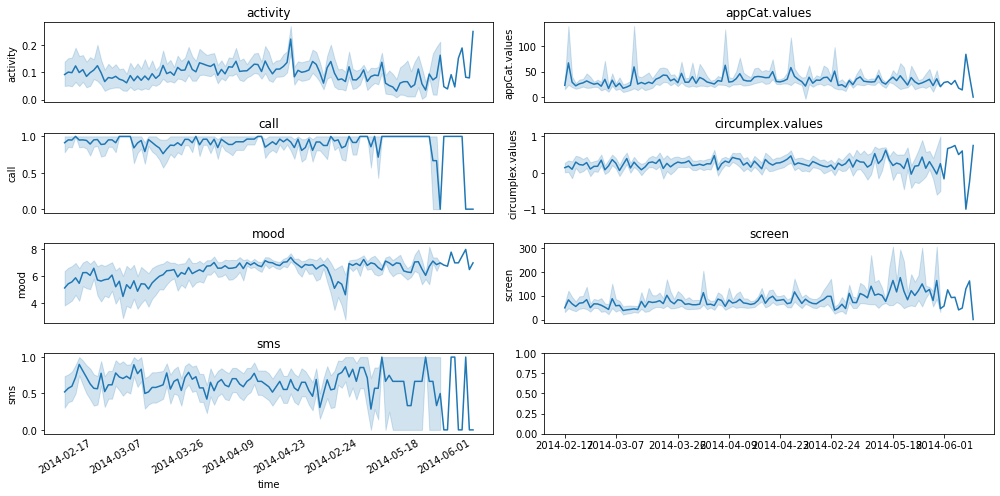

In [ ]:
# Plot line charts
df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [ ]:
# Indexing Batches
# train_df = df.sort_values(by=['Date']).copy()
train_df = df.copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
# d = pd.to_datetime(train_df.index)
# train_df['Month'] = d.strftime("%m")
# train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,activity,appCat.values,call,circumplex.values,mood,screen,sms
0,0.041548,21.900333,1.0,0.125000,6.250000,22.162157,0.0
1,0.015309,22.311789,1.0,-0.142857,6.500000,56.542267,0.0
2,0.064394,37.849680,1.0,0.100000,6.600000,137.494630,1.0
3,0.039220,38.048714,1.0,0.000000,6.333334,117.011760,1.0
4,0.042033,12.750950,1.0,0.600000,7.200000,33.210304,1.0


In [ ]:
# List of considered Features
FEATURES = ['activity', 'appCat.values', 'call', 'circumplex.values', 'mood', 'screen', 'sms'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['mood']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['activity', 'appCat.values', 'call', 'circumplex.values', 'mood', 'screen', 'sms']


,activity,appCat.values,call,circumplex.values,mood,screen,sms,Prediction
1968,0.012704,29.703531,1.0,-0.100000,6.2,113.607750,1.0,6.2
1969,0.103301,27.164436,1.0,0.600000,8.2,113.657684,1.0,8.2
1970,0.169354,32.128033,1.0,-0.166667,7.0,118.978035,1.0,7.0
1971,0.192901,27.741684,1.0,-0.600000,6.8,86.342250,1.0,6.8
1972,0.113149,20.604250,0.0,-0.500000,7.0,59.264908,1.0,7.0


In [ ]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['mood'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1973, 7)


In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 3

# Prediction Index
index_Close = data.columns.get_loc("mood")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1529, 50, 7) (1529,)
(394, 50, 7) (394,)
0.7714285989795928
0.7714285989795928


In [ ]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

350 50 7


2022-04-19 16:47:48.360308: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 16:47:48.361692: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
# Training the model
epochs = 5
batch_size = 10
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Train on 1529 samples, validate on 394 samples
Epoch 1/5
1529/1529 [==============================] - 67s 44ms/step - loss: 0.0313 - val_loss: 0.0131
Epoch 2/5
1529/1529 [==============================] - 68s 44ms/step - loss: 0.0242 - val_loss: 0.0110
Epoch 3/5
1529/1529 [==============================] - 68s 44ms/step - loss: 0.0213 - val_loss: 0.0123
Epoch 4/5
1529/1529 [==============================] - 72s 47ms/step - loss: 0.0202 - val_loss: 0.0140
Epoch 5/5
1529/1529 [==============================] - 74s 48ms/step - loss: 0.0225 - val_loss: 0.0119


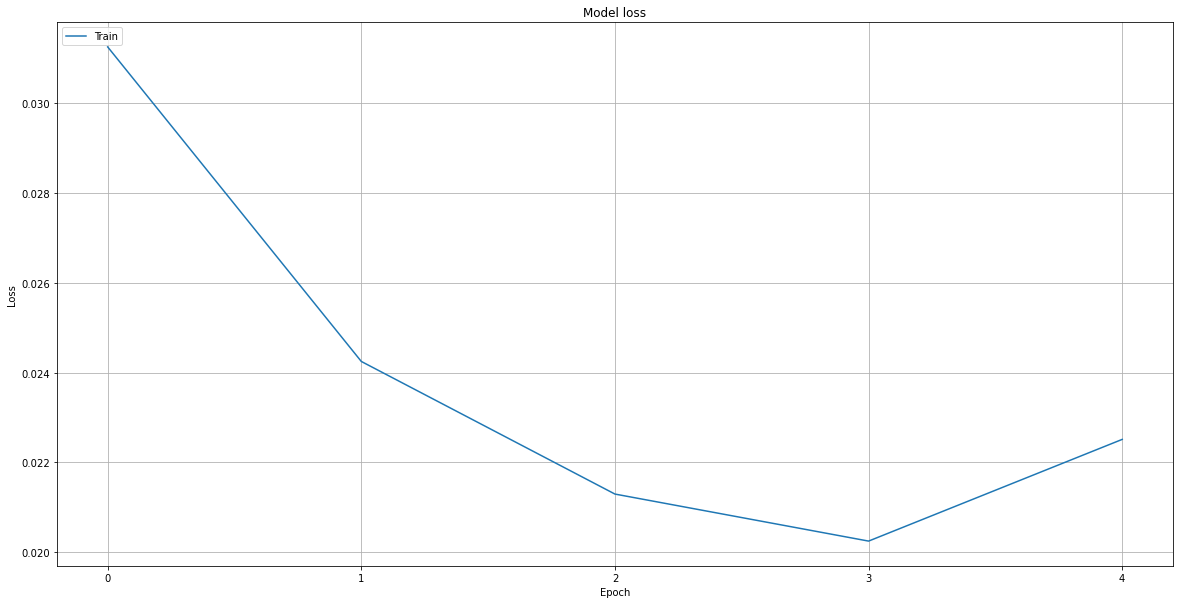

In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

NameError: name 'model' is not defined